# Heart Disease: An Exploration of Feature Engineering

The [Heart Disease UCI](https://www.kaggle.com/ronitf/heart-disease-uci) dataset is taken from Kaggle.

Attributes of the 303 entries are as follows:
> 1. Age as **age**
> 2. Sex as **sex** (1 as male, 0 as female)
> 3. Chest pain type (4 values) as **cp**
> 4. Resting blood pressure as **trestbps**
> 5. Serum cholestoral in mg/dl as **chol**
> 6. Fasting blood sugar > 120 mg/dl as **fbs**
> 7. Resting electrocardiographic results (values 0,1,2) as **restecg**
> 8. Maximum heart rate achieved as **thalach**
> 9. Exercise induced angina as **exang**
> 10. Oldpeak = ST depression induced by exercise relative to rest as **oldpeak**
> 11. Slope of the peak exercise ST segment as **slope**
> 12. Number of major vessels (0-3) colored by flourosopy as **ca**
> 13. Thal: 3 = normal; 6 = fixed defect; 7 = reversable defect as **thal**
> 14. Presence of heart disease as **target**

Goal: Predict the percentage of likelihood that someone has heart disease

In [54]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn import preprocessing
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import shap #for SHAP values

import statsmodels.formula.api as smf

In [86]:
data_folder = 'C:\\Users\\paulb\\OneDrive\\Desktop\\Data Science\\Data Sets\\Heart Disease UCI\\'
df = pd.read_csv(data_folder+'heart.csv')

In [56]:
print(len(df))
df.head()

303


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [57]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [58]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [59]:
def normalize(dataset):
    dataNorm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
    return dataNorm
df_normalized = normalize(df)

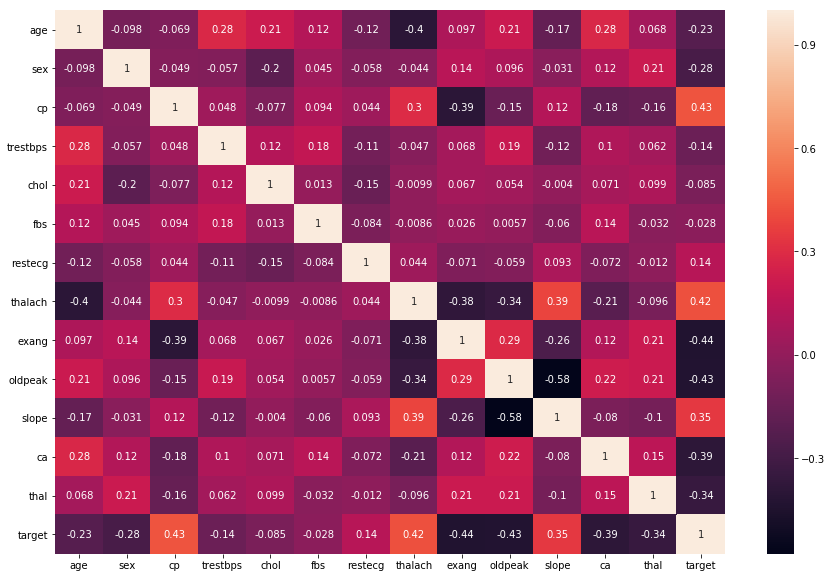

In [60]:
plt.figure(figsize=(15,10))
sns.heatmap(df_normalized.corr(), annot=True)

In [61]:
linear_formula = 'target ~ age+sex+cp+trestbps+chol+fbs+restecg+thalach+exang+oldpeak+slope+ca+thal'
lm = smf.ols(formula=linear_formula, data=df_normalized).fit()

In [62]:
print(lm.rsquared)
print(lm.params)

0.5175499644256842
Intercept    0.787782
age         -0.039380
sex         -0.195996
cp           0.338110
trestbps    -0.211042
chol        -0.154850
fbs          0.017374
restecg      0.099696
thalach      0.395532
exang       -0.144046
oldpeak     -0.364490
slope        0.157958
ca          -0.402409
thal        -0.357118
dtype: float64


## Selection of Features

In [63]:
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [64]:
df.sex = df.sex.map({0: 'female', 1: 'male'})
df.chest_pain_type = df.chest_pain_type.map({0:'none', 
                                             1:'typical_angina', 
                                             2:'atypical_angina', 
                                             3:'nonanginal_pain', 
                                             4:'asymptomatic'})
df.fasting_blood_sugar = df.fasting_blood_sugar.map({0:'below_120mg', 1:'above_120mg'})
df.rest_ecg = df.rest_ecg.map({0:'normal', 1:'st_t_wave_abnormality', 2:'left_ventricular_hypertrophy' })
df.exercise_induced_angina = df.exercise_induced_angina.map({0:'no', 1:'yes'})
df.st_slope = df.st_slope.map({0:'none', 1:'upsloping', 2:'flat'})
df.thalassemia = df.thalassemia.map({0:'none', 1:'normal', 2:'fixed_defect', 3:'reversable_defect'})

In [65]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,male,nonanginal_pain,145,233,above_120mg,normal,150,no,2.3,none,0,normal,1
1,37,male,atypical_angina,130,250,below_120mg,st_t_wave_abnormality,187,no,3.5,none,0,fixed_defect,1
2,41,female,typical_angina,130,204,below_120mg,normal,172,no,1.4,flat,0,fixed_defect,1
3,56,male,typical_angina,120,236,below_120mg,st_t_wave_abnormality,178,no,0.8,flat,0,fixed_defect,1
4,57,female,none,120,354,below_120mg,st_t_wave_abnormality,163,yes,0.6,flat,0,fixed_defect,1


In [66]:
df.isnull().values.any()

False

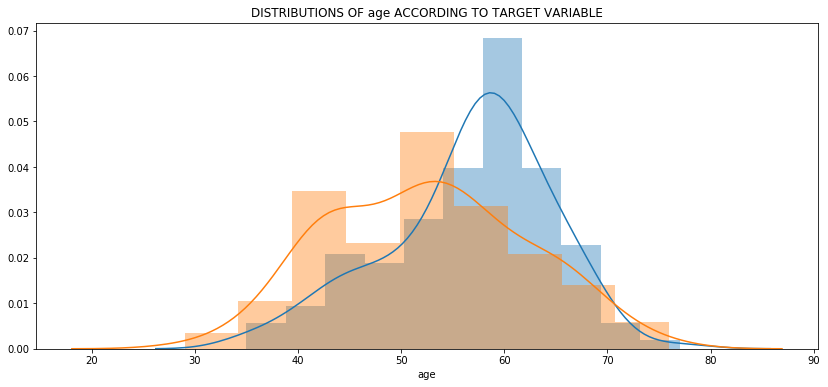

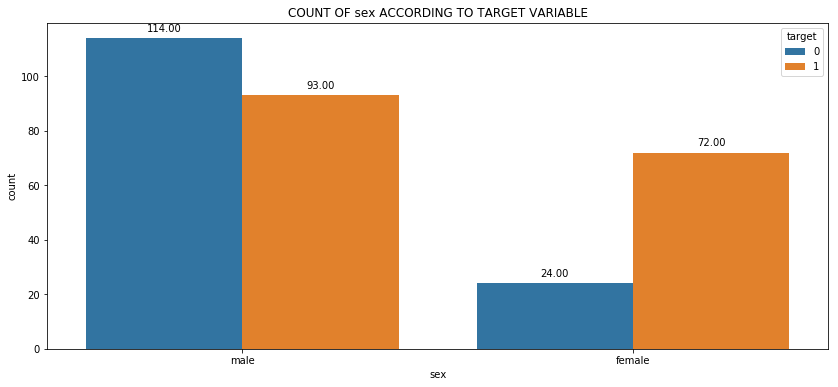

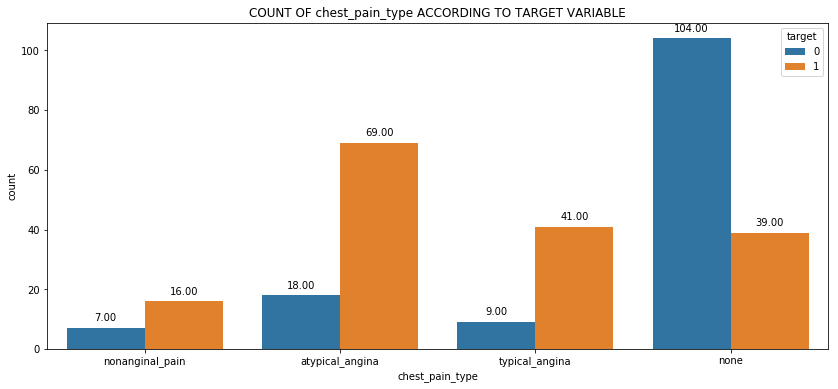

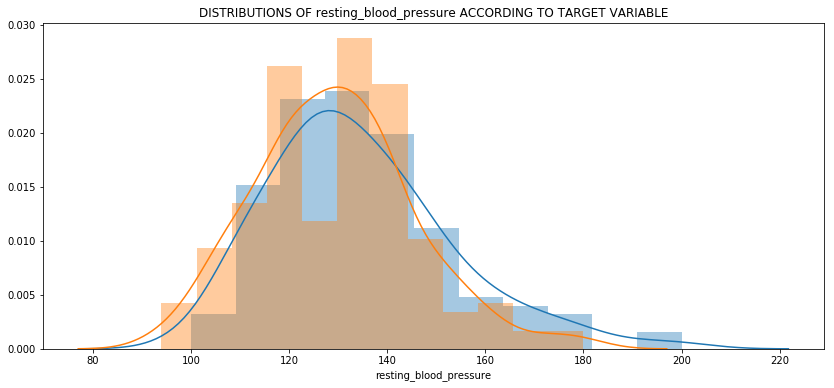

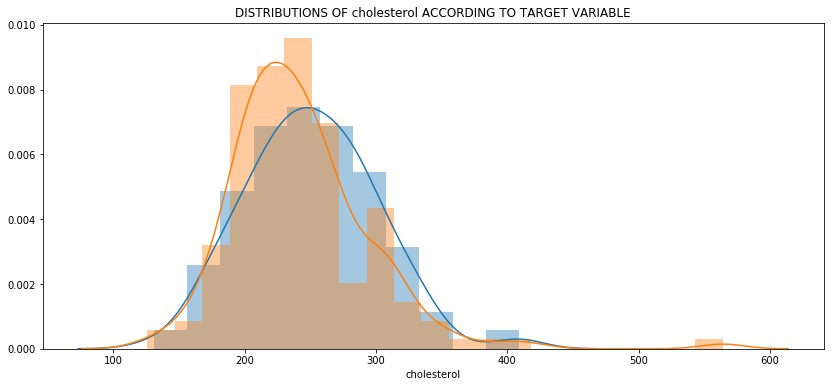

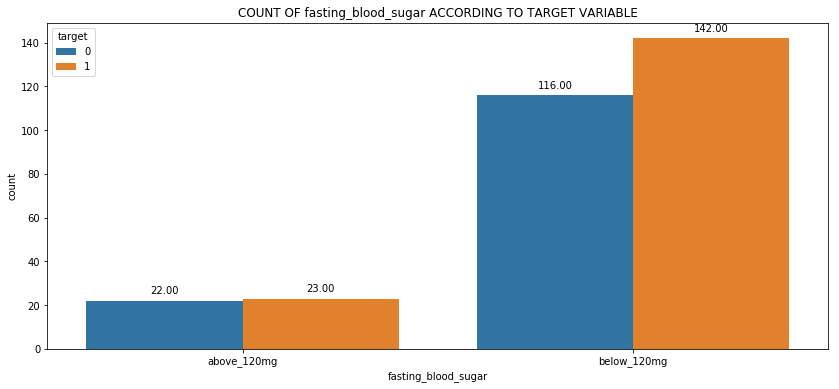

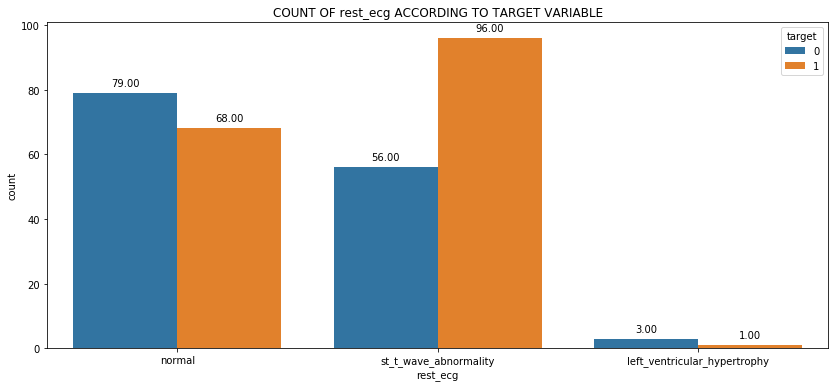

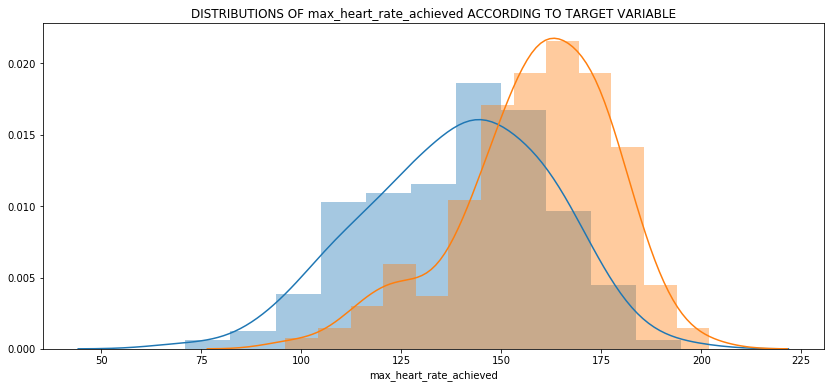

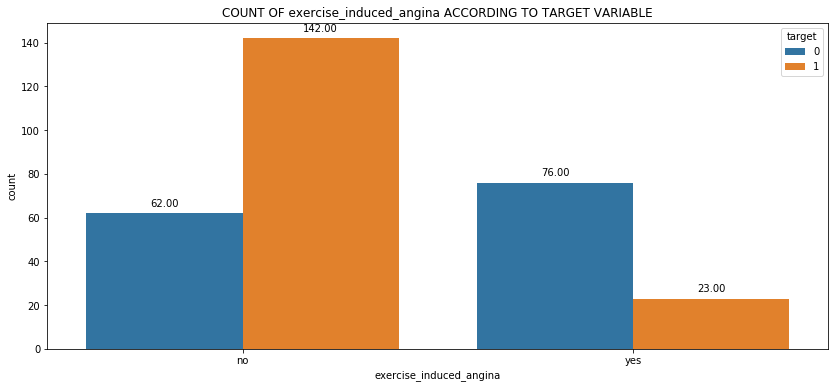

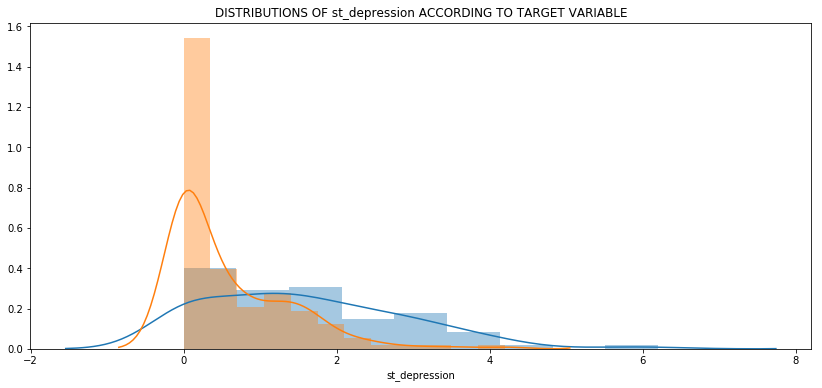

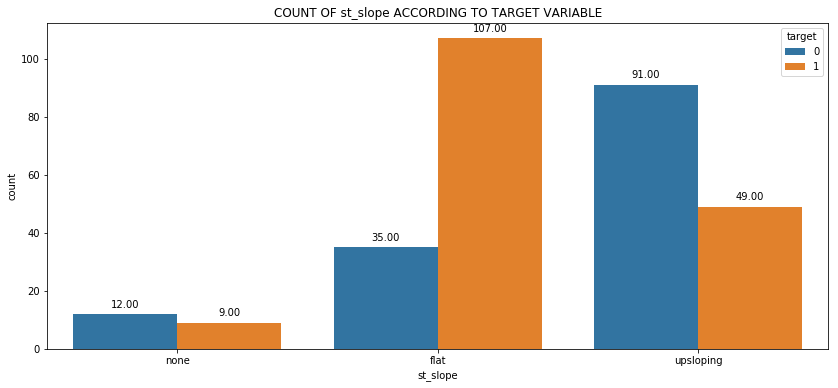

<Figure size 1008x432 with 0 Axes>

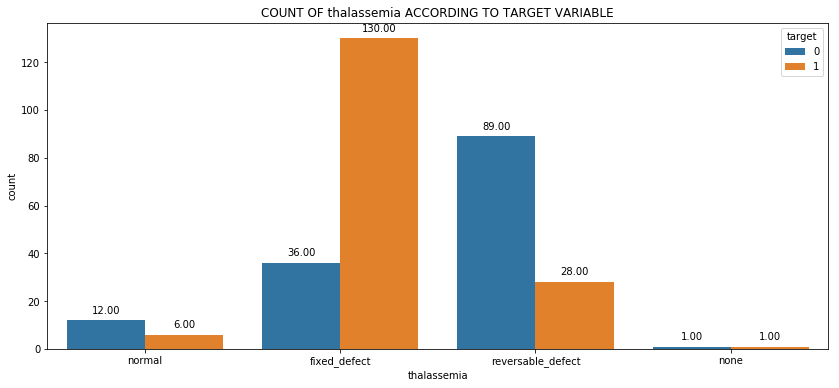

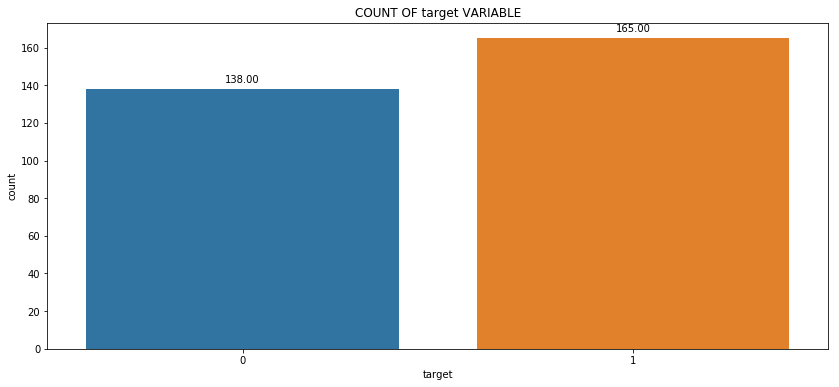

In [67]:
for col in df.columns:
    plt.figure(figsize=(14,6))
    if col == 'target':
        pass
    elif len(df[col].unique()) < 5: #for categorical variables
        ax = sns.countplot(x=col, hue="target", data=df)
        plt.title('COUNT OF ' + col + ' ACCORDING TO TARGET VARIABLE')
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.2f'), 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 10), 
                        textcoords = 'offset points')
        plt.show()
    elif len(df[col].unique()) > 5: #for continuous variables
        sns.distplot(df[df.target == 0][col])
        sns.distplot(df[df.target == 1][col])
        plt.title('DISTRIBUTIONS OF ' + col + ' ACCORDING TO TARGET VARIABLE')
        plt.show()

ax = sns.countplot(x='target', data=df)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')
plt.title('COUNT OF ' + col + ' VARIABLE')
plt.show()

In [68]:
#pd.cut(df.st_depression, bins=[np.linspace(0,8,33)]).value_counts().sort_index()
#np.linspace(0,8,33)
custom_bucket_array = np.linspace(0,8,16,endpoint=False)
pd.cut(df.st_depression, custom_bucket_array).value_counts().sort_index()
df['st_depression_binned'] = pd.cut(df.st_depression, custom_bucket_array)
df.groupby(['st_depression_binned'])['target'].mean()

st_depression_binned
(0.0, 0.5]    0.750000
(0.5, 1.0]    0.511111
(1.0, 1.5]    0.526316
(1.5, 2.0]    0.400000
(2.0, 2.5]    0.250000
(2.5, 3.0]    0.111111
(3.0, 3.5]    0.142857
(3.5, 4.0]    0.000000
(4.0, 4.5]    0.333333
(4.5, 5.0]         NaN
(5.0, 5.5]         NaN
(5.5, 6.0]    0.000000
(6.0, 6.5]    0.000000
(6.5, 7.0]         NaN
(7.0, 7.5]         NaN
Name: target, dtype: float64

In [69]:
print(df.groupby(['st_depression_binned','sex'])['target'].mean())
print(df.groupby(['st_depression_binned','sex'])['target'].count())

st_depression_binned  sex   
(0.0, 0.5]            female    0.916667
                      male      0.666667
(0.5, 1.0]            female    0.812500
                      male      0.344828
(1.0, 1.5]            female    0.785714
                      male      0.375000
(1.5, 2.0]            female    0.600000
                      male      0.320000
(2.0, 2.5]            male      0.250000
(2.5, 3.0]            female    0.250000
                      male      0.071429
(3.0, 3.5]            female    0.000000
                      male      0.166667
(3.5, 4.0]            female    0.000000
                      male      0.000000
(4.0, 4.5]            male      0.333333
(5.5, 6.0]            male      0.000000
(6.0, 6.5]            female    0.000000
Name: target, dtype: float64
st_depression_binned  sex   
(0.0, 0.5]            female    12
                      male      24
(0.5, 1.0]            female    16
                      male      29
(1.0, 1.5]            female    14


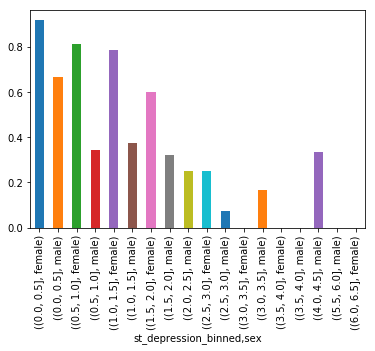

In [70]:
df.groupby(['st_depression_binned','sex'])['target'].mean().plot(kind='bar')

In [71]:
df.groupby(['st_slope','thalassemia'])['target'].agg('count')

st_slope   thalassemia      
flat       fixed_defect         102
           none                   1
           normal                 2
           reversable_defect     37
none       fixed_defect           8
           normal                 3
           reversable_defect     10
upsloping  fixed_defect          56
           none                   1
           normal                13
           reversable_defect     70
Name: target, dtype: int64

In [72]:
df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.head(5)

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_nonanginal_pain,chest_pain_type_none,...,"st_depression_binned_(2.5, 3.0]","st_depression_binned_(3.0, 3.5]","st_depression_binned_(3.5, 4.0]","st_depression_binned_(4.0, 4.5]","st_depression_binned_(4.5, 5.0]","st_depression_binned_(5.0, 5.5]","st_depression_binned_(5.5, 6.0]","st_depression_binned_(6.0, 6.5]","st_depression_binned_(6.5, 7.0]","st_depression_binned_(7.0, 7.5]"
0,63,145,233,150,2.3,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,37,130,250,187,3.5,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,41,130,204,172,1.4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,56,120,236,178,0.8,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,57,120,354,163,0.6,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [73]:
df_dummy.columns

Index(['age', 'resting_blood_pressure', 'cholesterol',
       'max_heart_rate_achieved', 'st_depression', 'num_major_vessels',
       'target', 'sex_male', 'chest_pain_type_nonanginal_pain',
       'chest_pain_type_none', 'chest_pain_type_typical_angina',
       'fasting_blood_sugar_below_120mg', 'rest_ecg_normal',
       'rest_ecg_st_t_wave_abnormality', 'exercise_induced_angina_yes',
       'st_slope_none', 'st_slope_upsloping', 'thalassemia_none',
       'thalassemia_normal', 'thalassemia_reversable_defect',
       'st_depression_binned_(0.5, 1.0]', 'st_depression_binned_(1.0, 1.5]',
       'st_depression_binned_(1.5, 2.0]', 'st_depression_binned_(2.0, 2.5]',
       'st_depression_binned_(2.5, 3.0]', 'st_depression_binned_(3.0, 3.5]',
       'st_depression_binned_(3.5, 4.0]', 'st_depression_binned_(4.0, 4.5]',
       'st_depression_binned_(4.5, 5.0]', 'st_depression_binned_(5.0, 5.5]',
       'st_depression_binned_(5.5, 6.0]', 'st_depression_binned_(6.0, 6.5]',
       'st_depression

In [74]:
with_disease = df[df_dummy.target == 1]
without_disease = df[df_dummy.target == 0]

### Guided Exploration Using Kernel

In [87]:
df.dtypes

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object

In [88]:
dt = pd.get_dummies(df, drop_first=True)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', axis=1), 
                                                    dt['target'], 
                                                    test_size = .2, 
                                                    random_state=10)

c:\users\paulb\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


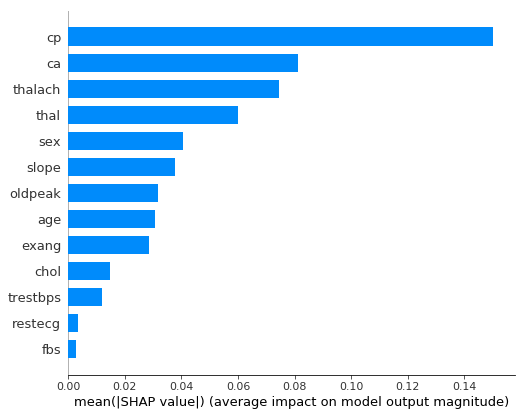

In [90]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In [91]:
array = df.values
X = array[:,0:6&7:]
Y = array[:,6]

In [92]:
# Feature extraction through Chi-squared (comparing observed by expected values)
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# Summarize scores
np.set_printoptions(precision=3)
print(fit.scores_)

features = fit.transform(X)
# Summarize selected features
print(features[0:5,:])

[ 13.848   1.171   2.317  16.402 100.884   1.956]
[[ 63.   3. 145. 233.]
 [ 37.   2. 130. 250.]
 [ 41.   1. 130. 204.]
 [ 56.   1. 120. 236.]
 [ 57.   0. 120. 354.]]


In [93]:
X

array([[ 63.,   1.,   3., 145., 233.,   1.],
       [ 37.,   1.,   2., 130., 250.,   0.],
       [ 41.,   0.,   1., 130., 204.,   0.],
       ...,
       [ 68.,   1.,   0., 144., 193.,   1.],
       [ 57.,   1.,   0., 130., 131.,   0.],
       [ 57.,   0.,   1., 130., 236.,   0.]])

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['target'], axis=1),
                                                   df['target'],
                                                   test_size=.33,
                                                   random_state=42)
wide_x = pd.get_dummies(X_train, drop_first=True)
wide_x.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
37,54,1,2,150,232,0,0,165,0,1.6,2,0,3
16,58,0,2,120,340,0,1,172,0,0.0,2,0,2
126,47,1,0,112,204,0,1,143,0,0.1,2,0,2
291,58,1,0,114,318,0,2,140,0,4.4,0,3,1
273,58,1,0,100,234,0,1,156,0,0.1,2,1,3


In [95]:
# The only variable with insufficient variance is Fasting blood sugar > 120 mg/dl as fbs
selector = VarianceThreshold(threshold=0.8 * (1 - .8)).fit(wide_x)
wide_x[wide_x.columns[selector.get_support()]].head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal
37,54,1,2,150,232,0,165,0,1.6,2,0,3
16,58,0,2,120,340,1,172,0,0.0,2,0,2
126,47,1,0,112,204,1,143,0,0.1,2,0,2
291,58,1,0,114,318,2,140,0,4.4,0,3,1
273,58,1,0,100,234,1,156,0,0.1,2,1,3


In [96]:
selector = SelectKBest(score_func=f_regression, k=5).fit(wide_x, y_train)
five_kbest = wide_x[wide_x.columns[selector.get_support()]]
five_kbest.head()

,cp,thalach,exang,oldpeak,ca
37,2,165,0,1.6,0
16,2,172,0,0.0,0
126,0,143,0,0.1,0
291,0,140,0,4.4,3
273,0,156,0,0.1,1


In [97]:
list(five_kbest.columns)

['cp', 'thalach', 'exang', 'oldpeak', 'ca']